<a href="https://colab.research.google.com/github/siudd/amazon_web_scraping/blob/main/amazon_web_scraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install all required libraries

In [1]:
pip install requests beautifulsoup4 requests-html selenium

In [2]:
import pandas as pd
import urllib.parse
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import re
import time
import random
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from google.colab import drive

function *amazon_scrap* is the core for doing web scraping.  It accepts an *URL* (string) and perform scrap from amazon.  There is also a checking on the result and see if it is successful and if not, it will randomly sleep for 1-3 seconds and retry until sucessful.  It uses Selenium and BeautifulSoup to do the work and return a BeautifulSoup object

In [3]:
def amazon_scrap(sURL):
  #selenium config
  options = webdriver.ChromeOptions()
  options.add_argument('--ignore-certificate-errors')
  options.add_argument('--incognito')
  options.add_argument('--headless')
  options.add_argument("--window-size=1920,1200")
  options.add_argument("start-maximized")
  options.add_argument("disable-infobars")
  options.add_argument("--disable-extensions")
  options.add_argument("--disable-gpu")
  options.add_argument("--disable-dev-shm-usage")
  options.add_argument("--no-sandbox")
  driver = webdriver.Chrome(options=options)

  driver.get(sURL)
  webpage = driver.page_source
  bs4soup = BeautifulSoup(webpage, "lxml")
  while "<title>Amazon.ca Something Went Wrong / Quelque chose s'est mal passé</title>" in webpage:
    time.sleep(random.uniform(1,3))
    driver.get(sURL)
    webpage = driver.page_source
    bs4soup = BeautifulSoup(webpage, "lxml")
  driver.quit()
  return bs4soup

function *amazon_search* calls *amazon_scape* and further extract the information needed from a search result page.  It accepts a *Keyword* (string) and then pass to amazon_scrap with the base URL and a page no.  Normally search result return 7 pages so it will iterate from page 1 to 7.  ASIN, title, prices (including original discount & coupon), rating, bestseller / amazon's choice flag will be extracted.  It returns a dataframe object for further analysis if needed.

In [4]:
def amazon_search(sKeyWord):
  #get all items attributes from the search result
  page_no = 1
  item_count = 0
  search_result = []
  soup = BeautifulSoup("", 'lxml')
  while page_no <= 7:
    url = "https://www.amazon.ca/s?k=" + urllib.parse.quote(sKeyWord) + "&page=" + str(page_no)
    soup = amazon_scrap(url)
    product_listings = soup.find_all("div", {'class': 'a-section a-spacing-base'})
    for product in product_listings:
      #title
      title = product.find("span", {'class': 'a-size-base-plus a-color-base a-text-normal'}).text.strip()
      href = urllib.parse.unquote(product.find('a', class_='a-link-normal s-underline-text s-underline-link-text s-link-style a-text-normal')['href'])
      #ASIN & Href
      match = re.search(r'/[dg]p/([a-zA-Z0-9]{10})/', href)
      if match:
        asin = match.group(1)
        href = match.group(0)
      else:
        asin = 'video'
      #Prices
      try:
        price = float(product.find('span', class_='a-price').find('span', class_='a-offscreen').text.strip().split('$')[1].replace(',',''))
      except AttributeError:
        price = np.nan
      try:
        original_price = float(product.find('span', class_='a-price a-text-price').find('span', class_='a-offscreen').text.strip().split('$')[1].replace(',',''))
      except AttributeError:
        original_price = np.nan
      try:
        coupon = product.find('span', class_='s-coupon-unclipped').find('span', class_='a-size-base s-highlighted-text-padding aok-inline-block s-coupon-highlight-color').text.strip()
        if "Save" in coupon:
          coupon = float(coupon.split('$')[1].replace(',',''))
        else:
          coupon = float(coupon.split()[0].replace('$',''))
      except AttributeError:
        coupon = np.nan
      rating = product.find('span', class_='a-icon-alt')
      #Rating
      if rating:
          rating = float(rating.text.strip().split()[0])
      else:
          rating = np.nan
      #Bestseller / Amazon's Choice
      if product.find('div',class_='a-row a-badge-region'):
        badge_text = (product.find('div',class_='a-row a-badge-region').find('span',class_='a-badge-text')).text.strip()
        if badge_text == "Amazon's":
          bestseller = False
          amazon_choice = True
        elif badge_text == "Bestseller":
          bestseller = True
          amazon_choice = False
        else:
          bestseller = False
          amazon_choice = False
      else:
        bestseller = False
        amazon_choice = False
      search_result.append([item_count, asin, title, href, price, original_price, coupon, rating, bestseller, amazon_choice])
      item_count = item_count + 1
    page_no = page_no + 1

  dfResult = pd.DataFrame(search_result)
  dfResult = dfResult.rename(columns={0: 'ID'})
  dfResult = dfResult.rename(columns={1: 'ASIN'})
  dfResult = dfResult.rename(columns={2: 'Title'})
  dfResult = dfResult.rename(columns={3: 'Href'})
  dfResult = dfResult.rename(columns={4: 'Price'})
  dfResult = dfResult.rename(columns={5: 'Original_Price'})
  dfResult = dfResult.rename(columns={6: 'Coupon'})
  dfResult = dfResult.rename(columns={7: 'Rating'})
  dfResult = dfResult.rename(columns={8: 'Bestseller'})
  dfResult = dfResult.rename(columns={9: 'Amazon_Choice'})
  dfResult['Original_Price'] = dfResult.apply(lambda row: row['Price'] if pd.isna(row['Original_Price']) else row['Original_Price'], axis=1)
  dfResult['Price_After_Coupon'] = dfResult.apply(lambda row: row['Price'] - row['Coupon'] if not pd.isna(row['Coupon']) else row['Price'], axis=1)
  dfResult['Discount_Percentage'] = ((dfResult['Original_Price'] - dfResult['Price_After_Coupon']) / dfResult['Original_Price']) * 100
  return dfResult

In [5]:
df = amazon_search('wireless earbuds')

This plot shows the percentage of bestsellers / amazon's choice in the search result

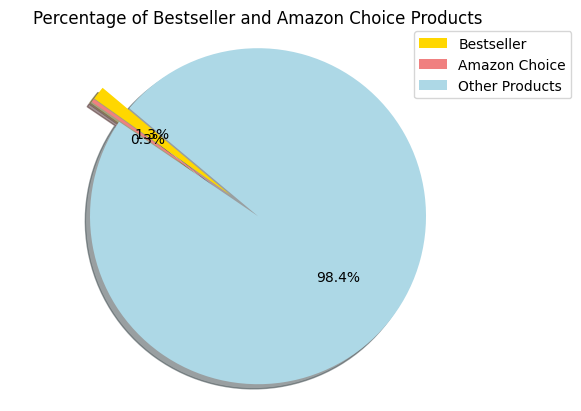

In [6]:
bestsellers_percentage = (df['Bestseller'].sum() / len(df)) * 100
amazon_choice_percentage = (df['Amazon_Choice'].sum() / len(df)) * 100
labels = ['Bestseller', 'Amazon Choice', 'Other Products']
sizes = [bestsellers_percentage, amazon_choice_percentage, 100 - (bestsellers_percentage + amazon_choice_percentage)]
colors = ['gold', 'lightcoral', 'lightblue']
explode = (0.1, 0.1, 0.1)
plt.pie(sizes, explode=explode, labels=None, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Percentage of Bestseller and Amazon Choice Products')
plt.gca().axis('equal')
plt.legend(labels, loc='best', bbox_to_anchor=(0.8, 0.8))
plt.show()

This plot shows top 10 products of the search result with biggest discount

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65292 (\N{FULLWIDTH COMMA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


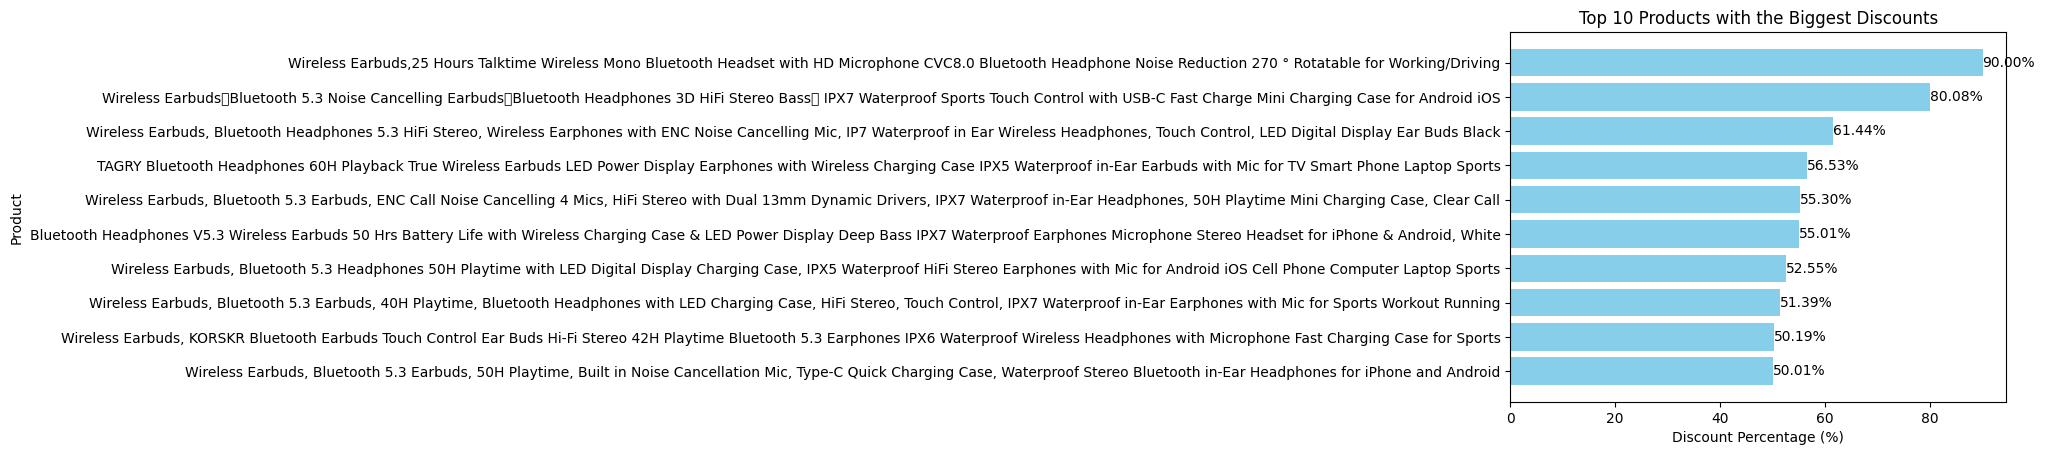

In [7]:
dfTop10Discount = df.sort_values(by='Discount_Percentage', ascending=False).head(10)
bars = plt.barh(dfTop10Discount['Title'], dfTop10Discount['Discount_Percentage'], color='skyblue')
plt.xlabel('Discount Percentage (%)')
plt.ylabel('Product', wrap=True)
plt.title('Top 10 Products with the Biggest Discounts')
plt.gca().invert_yaxis()
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.2f}%', ha='left', va='center')
plt.show()

This plot shows the distribution of rating of the products

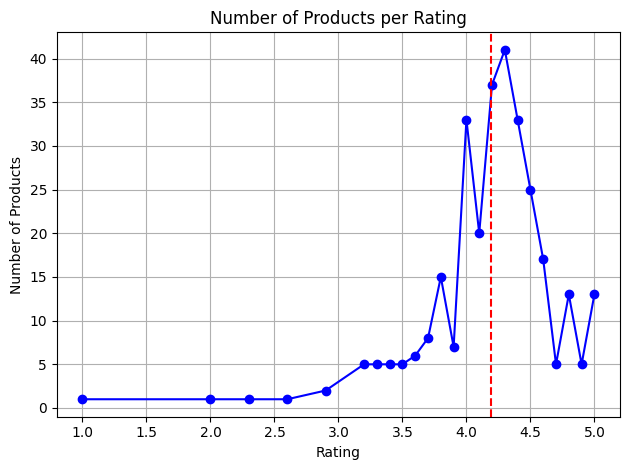

In [8]:
dfRating = df.groupby('Rating')['ASIN'].count().reset_index()
plt.plot(dfRating['Rating'], dfRating['ASIN'], marker='o', linestyle='-', color='b')
plt.axvline(x=df['Rating'].mean(), color='r', linestyle='--', label='Average Rating')
plt.xlabel('Rating')
plt.ylabel('Number of Products')
plt.title('Number of Products per Rating')
plt.grid(True)
plt.tight_layout()
plt.show()